# read datas

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)

import json
import numpy as np
import pandas as pd

with open('./tmp/typeid.json') as f:
    typeid = json.load(f)
with open('./tmp/bw_result.json') as f:
    typebw = json.load(f)
rentdf = pd.read_csv('./tmp/170911_rentclear.csv')
envdf = pd.read_csv('./tmp/env_clear.csv')

In [219]:
for key, value in typeid.items():
    print(key, value, typebw[key])

101 Food 300
102 Supermarket 2100
201 Bus 900
202 MRT 4300
203 UBike 3500
204 Train 6900
205 Exam 1700
206 Charger 5400
207 Towing 6000
301 BookStore 2400
302 DepartmentStore 1200
303 Library 4800
304 Museum 4100
305 Theater 2200
401 Park 1600
402 Scenic 1300
403 Sport 1400
501 School 4000
502 Hospital 5800
503 Pharmacy 3500
504 Police 6900
505 FireStation 6900


In [282]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KernelDensity
from sklearn.neighbors import KDTree

from LatLonToTWD97 import LatLonToTWD97
c = LatLonToTWD97()

In [283]:
%%time
rentdata = list(map(c.convert,rentdf.loc[:,['lat','lng']].values))
col = '{}:{}'
kdtree = {}
tmpdf = pd.DataFrame()
for key, value in typeid.items():
    name = col.format(key,typeid[key])
    bw = int(typebw[key])
    data = list(map(c.convert,envdf[envdf.typeID==int(key)].loc[:,['lat','lng']].values))
    kdtree[key] = KDTree(data)
    kde = KernelDensity(bandwidth=bw)
    kde.fit(data)
    tmpdf[name] = kde.score_samples(rentdata)

CPU times: user 1min 4s, sys: 50.1 ms, total: 1min 4s
Wall time: 1min 4s


In [305]:
%%time
col = '{}:{}'
countdf = pd.DataFrame()
for key, value in typeid.items():
    name = col.format(key,typeid[key])
    bw = int(typebw[key])
    countdf[name] = kdtree[key].query_radius(rentdata,r=bw, count_only=True)

CPU times: user 1.12 s, sys: 1.98 ms, total: 1.12 s
Wall time: 1.12 s


In [457]:
#conpute avg cost of food
foodf = envdf[envdf.typeID==101]
foodf.index=foodf.ID

In [536]:
def foodavg(array):
    if len(array)>0:
        try:
            return np.nanmean(foodf.loc[array,'cost'].dropna())
        except:
            pass
    else:
        return 0

In [537]:
favg = list(map(foodavg,kdtree['101'].query_radius(rentdata,r=typebw['101'])))

In [548]:
pd.DataFrame(favg).fillna(value=214).mean()

0    212.327744
dtype: float64

In [236]:
tmpdf.head()

,101:Food,102:Supermarket,201:Bus,202:MRT,203:UBike,204:Train,205:Exam,206:Charger,207:Towing,301:BookStore,...,304:Museum,305:Theater,401:Park,402:Scenic,403:Sport,501:School,502:Hospital,503:Pharmacy,504:Police,505:FireStation
0,-20.690013,-21.150177,-21.197688,-22.016565,-22.078798,-23.818845,-20.763704,-21.756216,-21.739868,-21.057701,...,-21.344104,-35.143631,-19.832454,-19.526913,-20.361726,-21.793622,-21.625844,-23.361540,-21.906159,-21.819031
1,-29.418300,-21.889287,-22.285826,-22.832456,-22.543544,-24.738320,-22.244460,-22.183499,-21.850956,-21.961800,...,-21.739857,-41.770144,-20.666102,-21.221613,-21.728591,-22.215835,-22.034202,-24.561982,-22.298620,-22.241080
2,-20.076350,-21.296837,-21.731911,-21.742753,-21.986086,-23.519200,-20.897927,-21.616462,-21.792917,-21.111542,...,-21.251749,-32.216696,-20.373445,-20.070019,-20.628840,-21.686197,-21.466098,-22.801697,-21.756647,-21.676334
3,-18.322282,-21.146282,-21.160755,-21.730500,-21.913950,-23.389006,-20.689591,-21.574648,-21.643634,-20.955411,...,-21.215287,-32.858452,-19.895306,-19.265852,-20.328033,-21.655434,-21.489876,-22.908381,-21.741798,-21.630667
4,-21.883530,-24.074363,-30.514663,-24.571018,-22.389492,-21.093035,-22.398776,-22.229883,-21.559772,-22.419500,...,-22.287442,-33.924655,-22.219667,-23.843253,-21.268603,-22.364983,-22.166921,-25.454403,-22.267152,-22.194877


In [306]:
countdf.head()

,101:Food,102:Supermarket,201:Bus,202:MRT,203:UBike,204:Train,205:Exam,206:Charger,207:Towing,301:BookStore,...,304:Museum,305:Theater,401:Park,402:Scenic,403:Sport,501:School,502:Hospital,503:Pharmacy,504:Police,505:FireStation
0,4,8,63,2,11,0,10,5,1,4,...,3,0,20,31,20,56,6,2,12,7
1,0,2,10,1,9,0,0,5,1,0,...,3,0,5,1,1,44,4,0,8,4
2,12,6,25,2,11,0,11,6,1,4,...,3,0,10,4,11,59,7,2,16,9
3,159,6,72,3,13,0,12,6,1,4,...,4,0,13,35,18,62,7,2,11,8
4,8,0,0,0,8,2,1,2,0,0,...,1,0,1,0,7,29,3,0,9,4


In [442]:
import re
lar = re.compile(r'^\d')
typecountdf = pd.DataFrame()
for key in countdf.columns:
    name = lar.findall(key)[0]
    if name in typecountdf.columns:
        typecountdf[name] = typecountdf[name] + countdf[key]
    else:
        typecountdf[name] = countdf[key]

In [443]:
typecountdf.head()

,1,2,3,4,5
0,12,92,9,71,83
1,2,26,5,7,60
2,18,56,10,25,93
3,165,107,11,66,90
4,8,13,3,8,45


In [106]:
expdf = tmpdf.applymap(lambda x:np.exp(x))

In [55]:
expdf.head(3)

,101:Food,102:Supermarket,201:Bus,202:MRT,203:UBike,204:Train,205:Exam,206:Charger,207:Towing,301:BookStore,...,304:Museum,305:Theater,401:Park,402:Scenic,403:Sport,501:School,502:Hospital,503:Pharmacy,504:Police,505:FireStation
0,3.215294e-05,0.000026,0.000025,0.000017,0.000016,0.000007,0.000031,0.000019,0.000019,0.000027,...,0.000023,2.336993e-08,0.000049,0.000058,0.000038,0.000019,0.000020,0.000008,0.000018,0.000018
1,4.091638e-07,0.000018,0.000014,0.000011,0.000013,0.000004,0.000015,0.000015,0.000018,0.000017,...,0.000019,8.506062e-10,0.000033,0.000025,0.000019,0.000015,0.000016,0.000005,0.000014,0.000015
2,4.369946e-05,0.000024,0.000019,0.000019,0.000017,0.000008,0.000029,0.000020,0.000019,0.000026,...,0.000024,1.009795e-07,0.000038,0.000044,0.000033,0.000020,0.000022,0.000011,0.000019,0.000020


In [416]:
#df = rentdf[['pet', 'rent']].join(tmpdf)
#df = rentdf[['pet', 'rent']].join(expdf)
df = rentdf[['pet', 'rent']].join(countdf)
#df = rentdf[['pet', 'rent']].join(typecountdf)

In [417]:
yn = {'N':0,'Y':1}
df['pet'] = df.pet.map(lambda x: yn.get(x))

In [419]:
from sklearn.preprocessing import Normalizer

nml = Normalizer(norm='max')
X = nml.fit_transform(df)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


In [427]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
# sc.fit(X_train)
# X_train_std = sc.transform(X_train)
# X_test_std = sc.transform(X_test)
X = sc.fit_transform(df)

In [428]:
# 直接使用scikit-learn實作
from sklearn.cluster import KMeans
# n_init=10, 隨機做十次  自動找出SSE最小的那一次
# max_iter=300, 或是 tol=1e-04, 為中止條件
clus = 4

km = KMeans(n_clusters=clus, 
            init='random', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=0)


In [429]:
y_km = km.fit_predict(X)

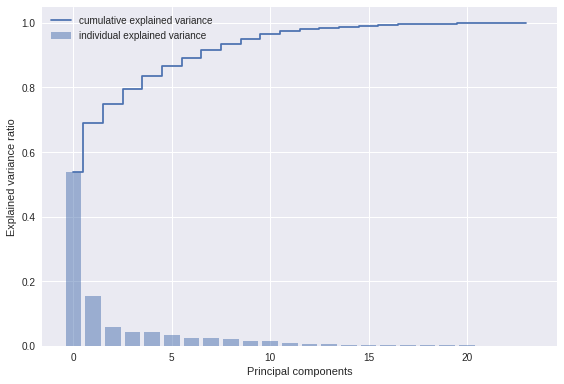

In [430]:
cov_mat = np.cov(X.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

#print('\nEigenvalues \n%s' % eigen_vals)

tot = sum(eigen_vals)
# 將特徵值排序  並計算百分比
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
# 加總
cum_var_exp = np.cumsum(var_exp)


length = len(X.T)
plt.bar(range(0, length), var_exp, alpha=0.5, align='center',
        label='individual explained variance')
plt.step(range(0, length), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()

plt.show()

In [431]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low

eigen_pairs.sort(reverse=True)

# 取前兩名重要的向量  並排列整齊
w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis]))

X_pca = X.dot(w)

In [432]:
X_end = pd.DataFrame(X_pca,columns=['x','y'])
X_end['y_km'] = y_km

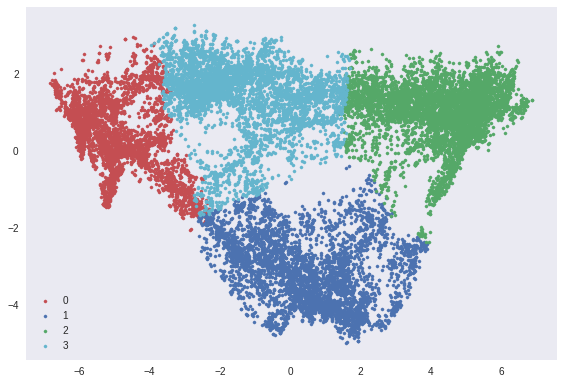

In [433]:
# 作圖

colors = ['r', 'b', 'g', 'c', 'm', 'y']

for l, c in zip(range(clus), colors):
    plt.scatter(X_end[y_km == l].x , 
                X_end[y_km == l].y, 
                c=c, label=l, s=10)


plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [434]:
resultdf = rentdf.join(X_df ,how='left', lsuffix='_left', rsuffix='_right')

In [435]:
resultdf['y'] = y_km

In [436]:
resultdf.groupby('y').count().ID

y
0    4685
1    4755
2    6420
3    5077
Name: ID, dtype: int64

In [440]:
resultdf.groupby('y').mean().sort_values('rent_left',ascending=False).T

y,2,3,0,1
Unnamed: 0,12735.921028,13123.158952,13764.699253,13658.222503
ID,12736.921028,13124.158952,13765.699253,13659.222503
cityID,105.576012,122.871184,227.694344,232.567613
rent_left,34730.565888,33982.067954,16011.830309,14983.021030
space_left,23.940405,28.525092,23.202239,16.726726
lat,25.044176,25.063089,25.089019,25.024901
lng,121.533899,121.550806,121.470770,121.478228
floor,5.678349,5.108135,5.626467,4.794742
unit,1602.390252,1327.013310,844.711001,1089.884033
pet_right,0.067718,-0.046859,-0.030117,-0.011723


In [438]:
pd.DataFrame(w, index=df.columns).apply(np.abs).sort_values([0,1], ascending=False)

,0,1
203:UBike,0.271128,0.036257
504:Police,0.266243,0.060674
502:Hospital,0.265674,0.072148
501:School,0.265085,0.093343
505:FireStation,0.262150,0.074559
206:Charger,0.261455,0.102431
303:Library,0.260921,0.075009
202:MRT,0.255918,0.162199
102:Supermarket,0.248973,0.028384
503:Pharmacy,0.244970,0.214032


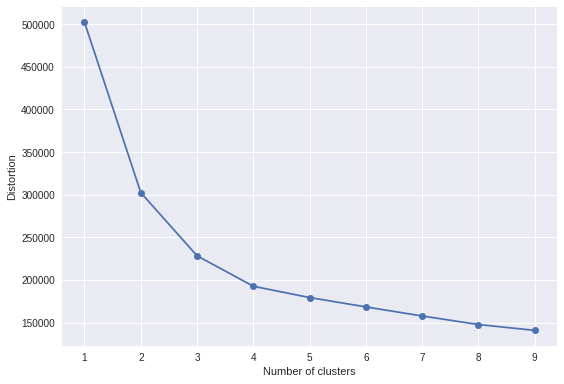

In [439]:
# 如果選取k越大 SSE必然越小
# 但分太多類別也沒有意義
# 這邊藉由SSE 的變化來選擇要分幾類
distortions = []
sup = 10
for i in range(1, sup):
    km = KMeans(n_clusters=i, 
                init='k-means++', 
                n_init=10, 
                max_iter=300, 
                random_state=0)
    km.fit(X)
    distortions.append(km.inertia_)
plt.plot(range(1, sup), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
plt.show()